Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

=====> /Users/rob/.julia/dev/StatisticalRethinking/notebooks/02


make: `/Users/rob/.julia/dev/StatisticalRethinking/notebooks/02/tmp/binomial' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.028, 0.028, 0.029, 0.029) seconds, 0.11 seconds total
Sampling took (0.044, 0.042, 0.039, 0.041) seconds, 0.17 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -86  2.3e-02     1.0    -88   -86   -85  1.9e+03  1.2e+04  1.0e+00
accept_stat__   0.89  2.1e-03    0.14   0.58  0.95   1.0  4.3e+03  2.6e+04  1.0e+00
stepsize__      0.90  2.8e-02   0.039   0.84  0.93  0.94  2.0e+00  1.2e+01  2.3e+13
treedepth__      1.9  1.9e-02    

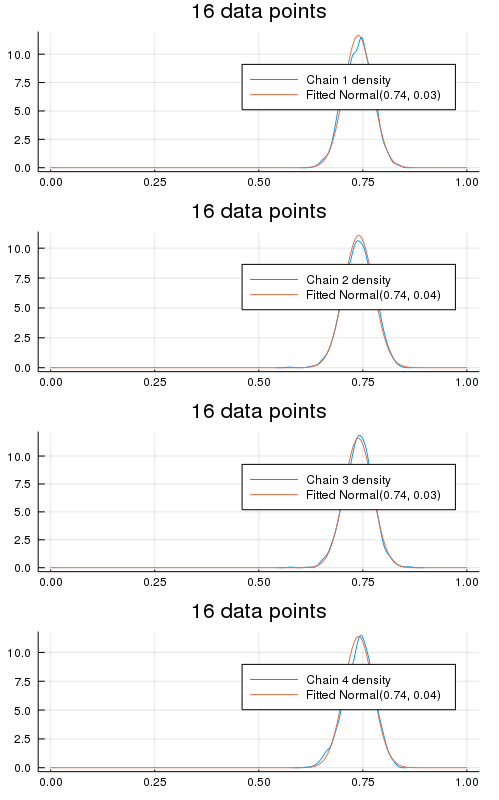

In [2]:
ProjDir = @__DIR__
cd(ProjDir) do
# Define the Stan language model
  binomialstanmodel = "
  // Inferring a Rate
  data {
    int N;
    int<lower=0> k[N];
    int<lower=1> n[N];
  }
  parameters {
    real<lower=0,upper=1> theta;
    real<lower=0,upper=1> thetaprior;
  }
  model {
    // Prior Distribution for Rate Theta
    theta ~ beta(1, 1);
    thetaprior ~ beta(1, 1);

    // Observed Counts
    k ~ binomial(n, theta);
  }
  "
# Make variables visible outisde the do loop
  global stanmodel, chn, sim, binomialdata
# Define the Stanmodel and set the output format to :mcmcchain.
  stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
    output_format=:mcmcchain)
# Use 16 observations
    N2 = 4^2
    d = Binomial(9, 0.66)
    n2 = Int.(9 * ones(Int, N2))
    k2 = rand(d, N2)
# Input data for cmdstan
    binomialdata = [
      Dict("N" => length(n2), "n" => n2, "k" => k2)
    ]
# Sample using cmdstan
    rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
      CmdStanDir=CMDSTAN_HOME)
# Describe the draws
    describe(chn)
# Plot the 4 chains
    if rc == 0
      p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
      x = 0:0.001:1
      for i in 1:4
        vals = convert.(Float64, chn.value[:, 1, i])
        @show res = fit_mle(Normal, vals)
        μ = round(res.μ, digits=2)
        σ = round(res.σ, digits=2)
        p[i] = density(vals, lab="Chain $i density", title="$(N2) data points")
        plot!(p[i], x, pdf.(Normal(res.μ, res.σ), x), lab="Fitted Normal($μ, $σ)")
      end
      plot(p..., layout=(4, 1))
    end

end # cd

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*